In [196]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xg

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import r2_score as R2 
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score
from scipy import stats
from scikeras.wrappers import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier




In [4]:
current_dir = os.getcwd()
print(current_dir)

/Users/aytug/Desktop/academic


In [5]:
encoded_data = pd.read_excel("final_sheet.xlsx")

In [6]:
final_imputed = pd.read_excel("final_imputed.xlsx")

In [7]:
print("Shape of the data:", final_imputed.shape)

Shape of the data: (29049, 19)


In [8]:
final_imputed_num = final_imputed.select_dtypes(include=['int64', 'float64'])

In [9]:
target = final_imputed_num['Price_log']
features = final_imputed_num.drop('Price_log', axis=1)

In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

In [11]:
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

In [12]:
pca_df = pd.DataFrame(data=pca_result,
                      columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
print(pca_df)

            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     -2.381792 -0.347740 -0.202872  0.043531 -0.917990 -0.025631 -0.697384   
1      0.579180 -1.162219 -2.109515  0.590692 -0.579296  1.163359  0.529393   
2     -3.034611 -0.848384  1.262012 -1.100069 -1.509611  0.599456 -0.025942   
3     -2.614523 -0.679012  0.634435 -0.564244 -1.540893  0.756597  0.160231   
4     -0.261836 -0.466913 -0.895048  0.708597 -1.410284  0.952361 -0.744789   
...         ...       ...       ...       ...       ...       ...       ...   
29044 -2.073980 -0.932645 -0.510605 -0.646794 -0.637955 -0.264723  0.263729   
29045  0.869288  1.502965  0.710529  0.189039 -1.039983 -0.412790  1.220091   
29046  2.889208 -0.938849 -2.383057 -0.610229  1.417324  0.807483  0.370114   
29047  2.792808  2.534327  0.289969 -0.447436 -1.317506  0.156596  0.633515   
29048  1.047698  3.280871 -0.359093 -0.204475 -1.518341  1.046788  0.933852   

            PC8       PC9      PC10      PC11  
0  

In [13]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

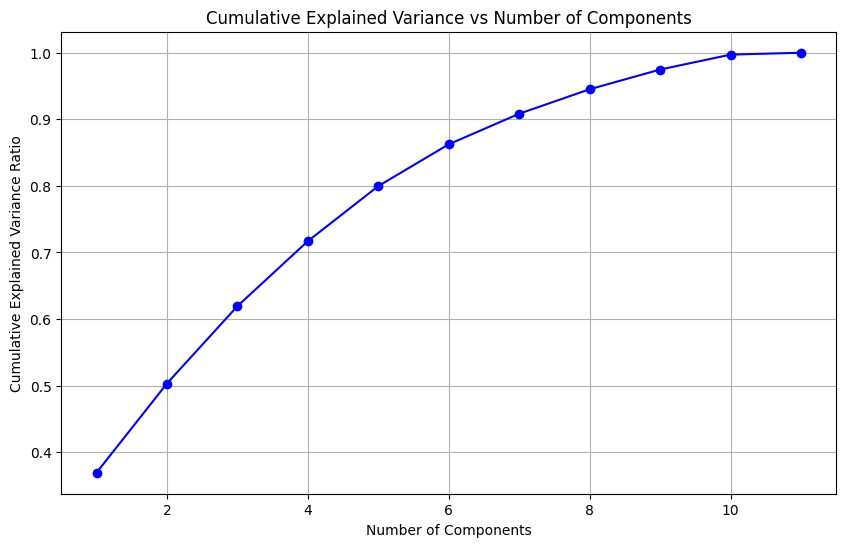

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), 
         cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

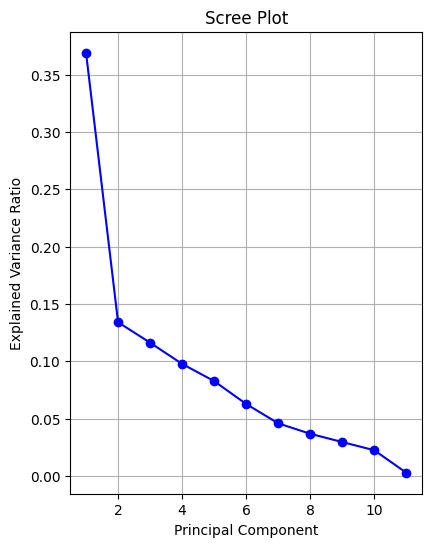

In [15]:
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), 
         explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)

In [16]:
print("\nExplained Variance Ratio by Component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.4f}")


Explained Variance Ratio by Component:
PC1: 0.3690
PC2: 0.1340
PC3: 0.1162
PC4: 0.0977
PC5: 0.0827
PC6: 0.0628
PC7: 0.0459
PC8: 0.0368
PC9: 0.0296
PC10: 0.0224
PC11: 0.0028


In [17]:
print("\nCumulative Explained Variance:")
for i, ratio in enumerate(cumulative_variance_ratio):
    print(f"Up to PC{i+1}: {ratio:.4f}")


Cumulative Explained Variance:
Up to PC1: 0.3690
Up to PC2: 0.5031
Up to PC3: 0.6192
Up to PC4: 0.7170
Up to PC5: 0.7997
Up to PC6: 0.8624
Up to PC7: 0.9084
Up to PC8: 0.9451
Up to PC9: 0.9747
Up to PC10: 0.9972
Up to PC11: 1.0000


Getting the loadings for component matrix:

In [18]:
loadings = pca.components_.T

In [19]:
loadings_df = pd.DataFrame(
    loadings,
    columns = [f'PC{i+1}' for i in range(loadings.shape[1])],
    index=features.columns
)

In [20]:
print(loadings_df.iloc[:, :5].round(3))

                    PC1    PC2    PC3    PC4    PC5
Rooms             0.449 -0.200  0.119  0.001 -0.001
Distance          0.254  0.454 -0.330 -0.243  0.123
Bedroom           0.447 -0.193  0.111  0.005  0.003
Bathroom          0.344 -0.118  0.046  0.453 -0.232
Car               0.300  0.083 -0.204  0.113  0.144
Landsize          0.329  0.085 -0.019 -0.478  0.300
YearBuilt         0.052  0.275 -0.632  0.499 -0.025
Latitude         -0.036 -0.466 -0.441 -0.124  0.513
Longtitude        0.157  0.597  0.259 -0.064  0.047
Propertycount    -0.070  0.116  0.391  0.467  0.742
BuildingArea_log  0.429 -0.161  0.083  0.090 -0.068


Factor analysis with Varimax rotation

In [21]:
fa = FactorAnalyzer(rotation='varimax', n_factors=5)
fa.fit(scaled_data)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [22]:
rotated_loadings = fa.loadings_

In [23]:
rotated_loadings_df = pd.DataFrame(
    rotated_loadings,
    columns=[f'Factor{i+1}' for i in range(rotated_loadings.shape[1])],
    index=features.columns
)

print(rotated_loadings_df)

                   Factor1   Factor2   Factor3   Factor4   Factor5
Rooms             0.905465  0.279952 -0.082973 -0.020240  0.279575
Distance          0.140225  0.625783  0.270040  0.202023  0.114598
Bedroom           0.891113  0.283740 -0.069364 -0.015424  0.272126
Bathroom          0.741887 -0.008144  0.167646  0.112930 -0.208399
Car               0.398705  0.350938  0.151078  0.029071 -0.114415
Landsize          0.325735  0.733719 -0.154038  0.032198 -0.020349
YearBuilt         0.021036  0.093153  0.992237 -0.049200 -0.017275
Latitude         -0.030914  0.031838  0.023151 -0.409140  0.050880
Longtitude        0.080890  0.259070  0.050869  0.892400  0.118989
Propertycount    -0.053473 -0.175209 -0.031918  0.155609  0.000212
BuildingArea_log  0.823918  0.280777 -0.021553  0.033969 -0.145145


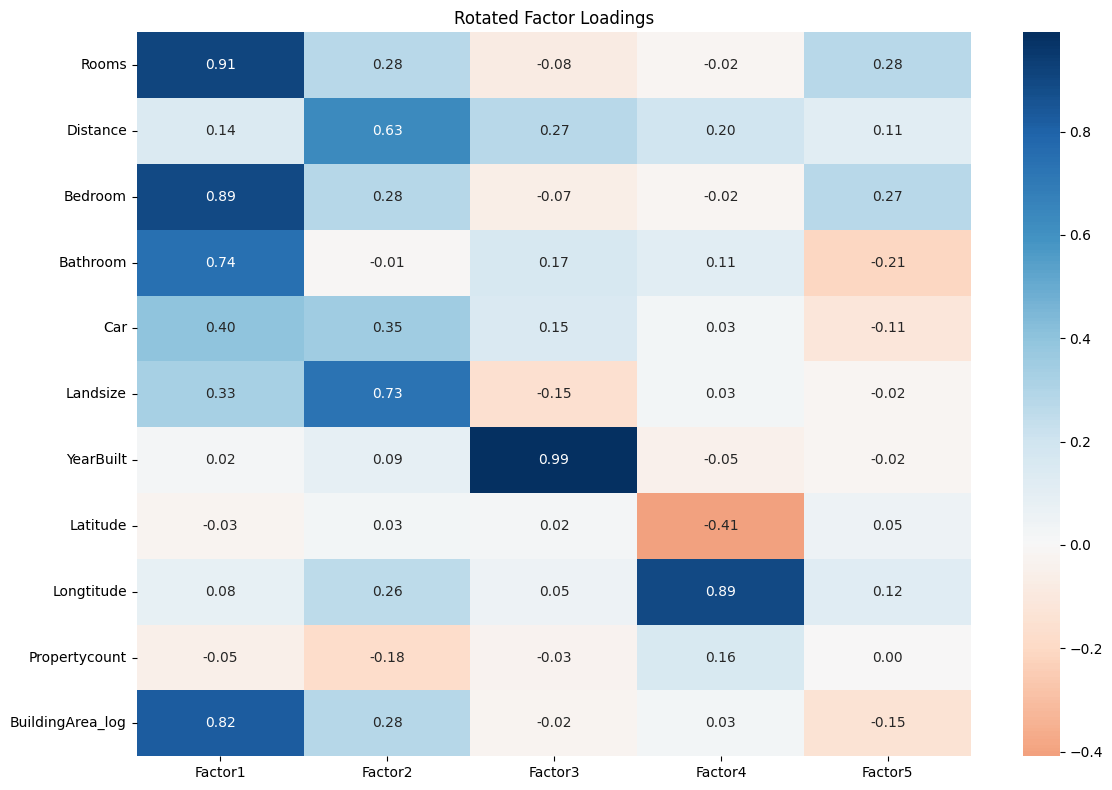

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(rotated_loadings_df,
            cmap='RdBu',
            center=0,
            annot=True,
            fmt='.2f')
plt.title('Rotated Factor Loadings')
plt.tight_layout()
plt.show()

Calculating communalities

In [25]:
communalities = fa.get_communalities()
communalities_df = pd.DataFrame(
    communalities,
    index=features.columns,
    columns=['Communality']
)

print("\nCommunalities:")
print(communalities_df.round(3))


Communalities:
                  Communality
Rooms                   0.984
Distance                0.538
Bedroom                 0.954
Bathroom                0.635
Car                     0.319
Landsize                0.670
YearBuilt               0.996
Latitude                0.172
Longtitude              0.887
Propertycount           0.059
BuildingArea_log        0.780


Variance explained by each factor:

In [26]:
variance = fa.get_factor_variance()
print("\nVariance explained by each factor:")
print(pd.DataFrame(
    variance,
    columns=[f'Factor{i+1}' for i in range(len(variance[0]))],
    index=['SS Loadings', 'Proportion Var', 'Cumulative Var']
).round(3))


Variance explained by each factor:
                Factor1  Factor2  Factor3  Factor4  Factor5
SS Loadings       3.139    1.398    1.148    1.048    0.260
Proportion Var    0.285    0.127    0.104    0.095    0.024
Cumulative Var    0.285    0.412    0.517    0.612    0.636


In [27]:
print("Top loading variables for each factor:")
for i in range(5):
    factor_loadings = rotated_loadings_df.iloc[:,i].abs().sort_values(ascending=False)
    print(factor_loadings.head().round(3))

Top loading variables for each factor:
Rooms               0.905
Bedroom             0.891
BuildingArea_log    0.824
Bathroom            0.742
Car                 0.399
Name: Factor1, dtype: float64
Landsize            0.734
Distance            0.626
Car                 0.351
Bedroom             0.284
BuildingArea_log    0.281
Name: Factor2, dtype: float64
YearBuilt    0.992
Distance     0.270
Bathroom     0.168
Landsize     0.154
Car          0.151
Name: Factor3, dtype: float64
Longtitude       0.892
Latitude         0.409
Distance         0.202
Propertycount    0.156
Bathroom         0.113
Name: Factor4, dtype: float64
Rooms               0.280
Bedroom             0.272
Bathroom            0.208
BuildingArea_log    0.145
Longtitude          0.119
Name: Factor5, dtype: float64


In [28]:
pca_df['Price_log'] = target.values

In [29]:
print("PCA Results with Target Variable:")
print(pca_df.head())

PCA Results with Target Variable:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.381792 -0.347740 -0.202872  0.043531 -0.917990 -0.025631 -0.697384   
1  0.579180 -1.162219 -2.109515  0.590692 -0.579296  1.163359  0.529393   
2 -3.034611 -0.848384  1.262012 -1.100069 -1.509611  0.599456 -0.025942   
3 -2.614523 -0.679012  0.634435 -0.564244 -1.540893  0.756597  0.160231   
4 -0.261836 -0.466913 -0.895048  0.708597 -1.410284  0.952361 -0.744789   

        PC8       PC9      PC10      PC11  Price_log  
0 -0.045179  0.759778 -0.242997 -0.016041  13.764218  
1  0.384121 -0.311608 -0.980355 -0.045222  13.641158  
2  0.102698 -0.105936 -0.013573 -0.028932  14.058458  
3  0.362709  0.488179 -0.616179 -0.045647  14.190517  
4  0.022362  0.518173  0.251355  0.001432  13.217775  


Relationship with the target:

In [30]:
correlations = pca_df.corr()['Price_log'].sort_values(ascending=False)
print("\nCorrelations with the Target:")
print(correlations)


Correlations with the Target:
Price_log    1.000000
PC1          0.567192
PC3          0.552863
PC9          0.130783
PC8          0.112422
PC11        -0.007038
PC4         -0.026437
PC7         -0.127780
PC6         -0.134396
PC5         -0.136116
PC2         -0.176021
PC10        -0.207111
Name: Price_log, dtype: float64


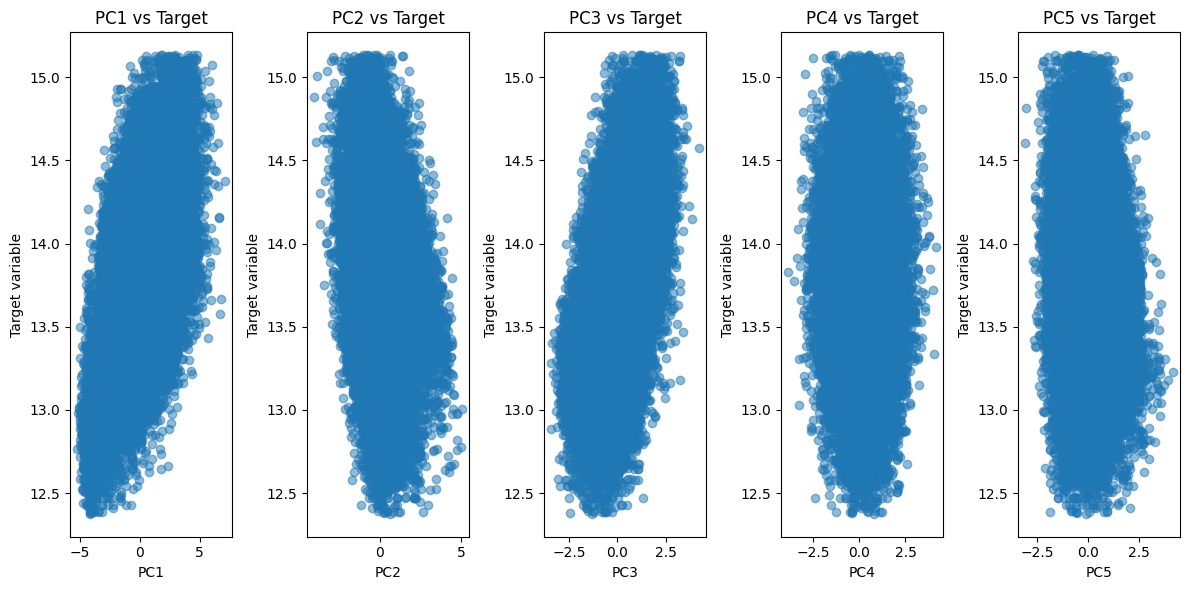

In [31]:
plt.figure(figsize=(12,6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.scatter(pca_df[f'PC{i+1}'], pca_df['Price_log'], alpha=0.5)
    plt.xlabel(f'PC{i+1}')
    plt.ylabel('Target variable')
    plt.title(f'PC{i+1} vs Target')
plt.tight_layout()
plt.show()    

Prepreation for modelling:

In [32]:
X = pca_df.drop('Price_log', axis=1)
y = pca_df['Price_log']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [33]:
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import r2_score as R2

mse = MSE(y_test, y_pred)
r2 = R2(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Model Performance:
Mean Squared Error: 0.0527
R-squared: 0.7870


In [34]:
#The results
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(model.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(f"\nFeature Importance:")
print(feature_importance)


Feature Importance:
   Feature  Importance
2      PC3    0.242876
9     PC10    0.206989
0      PC1    0.139561
8      PC9    0.112843
6      PC7    0.089706
7      PC8    0.088129
5      PC6    0.080222
1      PC2    0.072613
4      PC5    0.069916
10    PC11    0.013471
3      PC4    0.012405


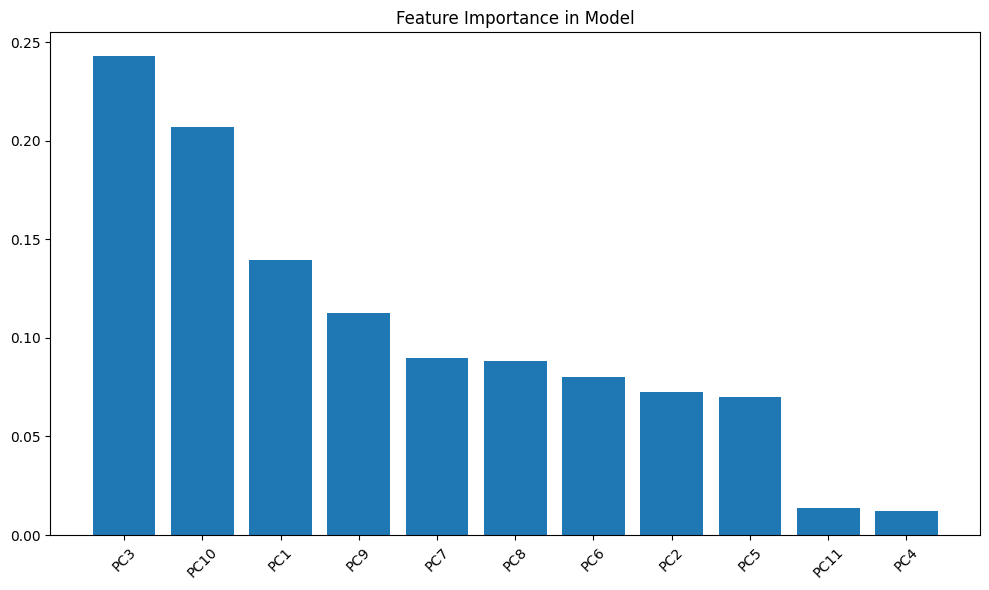

In [35]:
plt.figure(figsize=(10,6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance in Model')
plt.tight_layout()
plt.show()

Since the PC3 has the highest importance among these variables, the reason should be investigated:

In [36]:
pc2_loadings = rotated_loadings_df['Factor2'].sort_values(ascending=False)
print("Top 10 variables loading on PC2:")
print(pc2_loadings.head(10).round(3))

Top 10 variables loading on PC2:
Landsize            0.734
Distance            0.626
Car                 0.351
Bedroom             0.284
BuildingArea_log    0.281
Rooms               0.280
Longtitude          0.259
YearBuilt           0.093
Latitude            0.032
Bathroom           -0.008
Name: Factor2, dtype: float64


In [37]:
top_pc2_vars = pc2_loadings.head(5).index.tolist()

correlation_matrix = final_imputed_num[top_pc2_vars + ['Price_log']].corr()
print("\nCorrelation matrix for top variables regarding PC2:")
print(correlation_matrix['Price_log'].sort_values(ascending=False))


Correlation matrix for top variables regarding PC2:
Price_log           1.000000
BuildingArea_log    0.677941
Bedroom             0.555137
Landsize            0.372112
Car                 0.266494
Distance           -0.126581
Name: Price_log, dtype: float64


In [38]:
X_focused = pd.concat([
    pca_df[['PC2']],
    final_imputed_num[top_pc2_vars]
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_focused, pca_df['Price_log'],
                                                    test_size=.2, random_state=42)

#Fitting the model
model = LinearRegression()
model.fit(X_train, y_train)

#Evaluation
y_pred = model.predict(X_test)
mse = MSE(y_test, y_pred)
r2 = R2(y_test, y_pred)

print("\nFocused Model Performance:")
print(f"MSE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Focused Model Performance:
MSE: 0.0798
R-squared: 0.6770


/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


To compare with the whole model, full model must be defined:

In [39]:
X_full = pca_df.drop('Price_log', axis=1)
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, pca_df['Price_log'],
                                                              test_size=.2, random_state=42)

model_full = LinearRegression()
model_full.fit(X_train_full, y_train)

y_pred_full = model_full.predict(X_test_full)
mse_full = MSE(y_test, y_pred_full)
r2_full = R2(y_test, y_pred_full)

print("\nFull Model Performance:")
print(f"Mean Squared Error: {mse_full:.4f}")
print(f"R-squared: {r2_full:.4f}")

#Model comparison
print("\nModel Comparison:")
print(f"Focused Model R-squared: {r2:.4f}")
print(f"Full Model R-squared: {r2_full:.4f}")


Full Model Performance:
Mean Squared Error: 0.0527
R-squared: 0.7870

Model Comparison:
Focused Model R-squared: 0.6770
Full Model R-squared: 0.7870


/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [40]:
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 

Checking VIF values for focused data:

In [41]:
vif_df = pd.DataFrame()
vif_df["Variable"] = X_focused.columns
vif_df["VIF"] = [vif(X_focused.values, i) for i in range(X_focused.shape[1])]

print("\nVIF Values for Focused Model:")
print(vif_df.sort_values('VIF', ascending=False))


VIF Values for Focused Model:
           Variable        VIF
4           Bedroom  26.150776
5  BuildingArea_log  20.540026
2          Distance  10.945022
3               Car   7.136332
1          Landsize   5.039384
0               PC2   1.987542


In [233]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # replace X with your data

fa = FactorAnalyzer(n_factors=6, rotation='varimax')
fa.fit(X_scaled)

loadings = pd.DataFrame(fa.loadings_, columns=[f"PC{i+1}" for i in range(6)], index=X.columns)

print(loadings.round(3))

                    PC1    PC2    PC3    PC4    PC5    PC6
Typeh             0.253  0.807 -0.490  0.114 -0.165  0.041
Typet             0.036 -0.009  0.993  0.017  0.092  0.000
Typeu            -0.314 -0.907 -0.198 -0.142  0.117 -0.047
YearBuilt         0.055 -0.165  0.104  0.241  0.663  0.045
Distance          0.152  0.124  0.004  0.654  0.225  0.052
BuildingArea_log  0.798  0.285 -0.006  0.211 -0.040  0.121
Bathroom          0.797  0.091  0.037 -0.065  0.256  0.002
Car               0.387  0.115 -0.011  0.296  0.155  0.326
Rooms             0.797  0.261 -0.030  0.315 -0.173  0.029


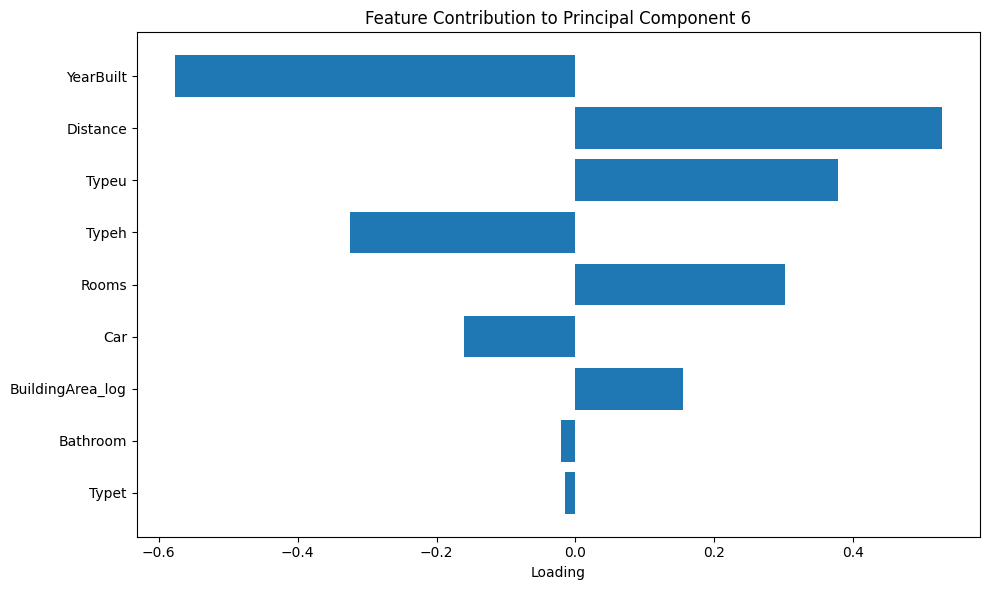

In [234]:

pc6_loadings = pca.components_[5]  # 6th PC = index 5


feature_names = X.columns  
pc6_df = pd.DataFrame({
    'Feature': feature_names,
    'PC6_Importance': pc6_loadings
})

# Take absolute values to show contribution magnitudes
pc6_df['Abs_Importance'] = pc6_df['PC6_Importance'].abs()

# Sort by absolute importance
pc6_df_sorted = pc6_df.sort_values(by='Abs_Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(pc6_df_sorted['Feature'], pc6_df_sorted['PC6_Importance'])
plt.title('Feature Contribution to Principal Component 6')
plt.xlabel('Loading')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Classification model:

In [42]:
#Checking the imbalance issue
median_price = encoded_data['Price_log'].median()
y_class = (encoded_data['Price_log'] > median_price).astype(int)

class_counts = np.bincount(y_class)
total_samples = len(y_class)
class_ratios = class_counts / total_samples

print("\nClass Distribution Analysis:")
print(f"Total samples: {total_samples}")
print(f"Class 0 (Price_log <= {median_price:.2f}): {class_counts[0]} samples ({class_ratios[0]:.2%})")
print(f"Class 1 (Price_log > {median_price:.2f}): {class_counts[1]} samples ({class_ratios[1]:.2%})")


Class Distribution Analysis:
Total samples: 29049
Class 0 (Price_log <= 13.75): 14534 samples (50.03%)
Class 1 (Price_log > 13.75): 14515 samples (49.97%)


In [43]:
imbalance_ratio = max(class_ratios) / min(class_ratios)
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")


Imbalance Ratio: 1.00


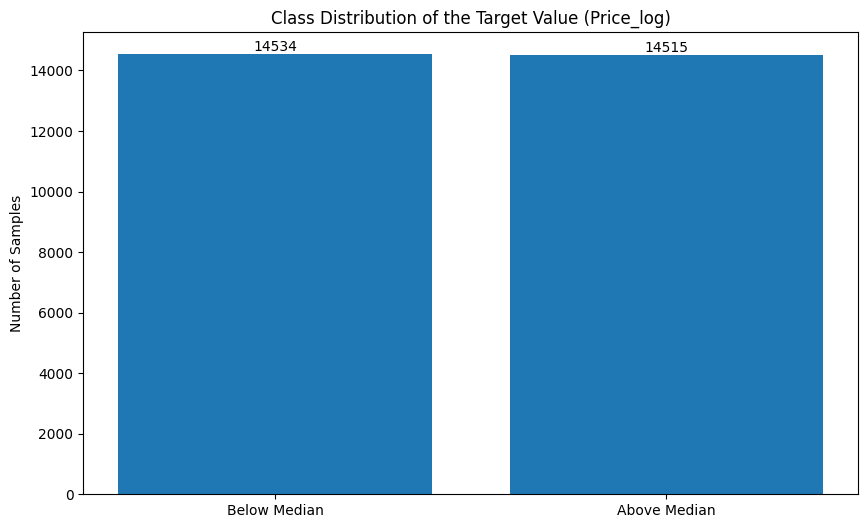

In [44]:
plt.figure(figsize=(10,6))
plt.bar(['Below Median', 'Above Median'], class_counts)
plt.title("Class Distribution of the Target Value (Price_log)")
plt.ylabel("Number of Samples")
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count}', ha='center', va='bottom')
plt.show()

In [45]:
#Determining if the data is imbalanced:
if imbalance_ratio > 1.5:
    print("\nThe data is imbalanced. The techniques can be used are:")
    print("1. SMOTE")
    print("2. Class weights in the model")
    print("3. Stratified sampling in cross-validation")
    print("4. Appropriate evaluation metrics")
else:
    print("\nThe data is distributed in balance.")    


The data is distributed in balance.


Cross - Validation

In [46]:
print(final_imputed.columns)

Index(['Rooms', 'Distance', 'Bedroom', 'Bathroom', 'Car', 'Landsize',
       'YearBuilt', 'Latitude', 'Longtitude', 'Propertycount', 'Price_log',
       'BuildingArea_log', 'Suburb', 'Type', 'CouncilArea', 'Method',
       'SellerG', 'Regionname', 'ParkingArea'],
      dtype='object')


In [47]:
type_cols = [col for col in encoded_data.columns if 'Type' in col]
print(type_cols)

['Typeh', 'Typet', 'Typeu', 'Type']


In [48]:
features = [
    "Typeh", "Typet", "Typeu", "YearBuilt", "Distance", "BuildingArea_log", "Bathroom",
    "Bedroom", "Car", "Rooms"
]

In [49]:
X = encoded_data[features]
y = encoded_data["Price_log"]

In [50]:
# Add constant to X for statsmodels
X_with_const = sm.add_constant(X)

In [51]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Conducting models:

1. Multiple Linear Regression Model

Checking the assumptions:

In [52]:
#Linearity

discrete_vars = ["Type", "Bathroom", "Bedroom", "Car", "Rooms"]
continuous_vars = ["YearBuilt", "BuildingArea_log", "Distance"]


KeyError: 'Type'

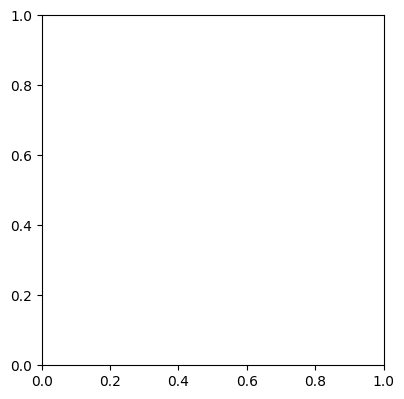

In [53]:

plt.figure(figsize=(15,10))
for i, feature in enumerate(discrete_vars, 1):
    plt.subplot(2,3,i)
    sns.boxplot(x=X[feature], y=y)
    plt.scatter(X[feature], y, alpha=0.5)
    plt.xlabel('Price_log')
    plt.title(f'Price vs {feature}')
plt.tight_layout()
plt.show()


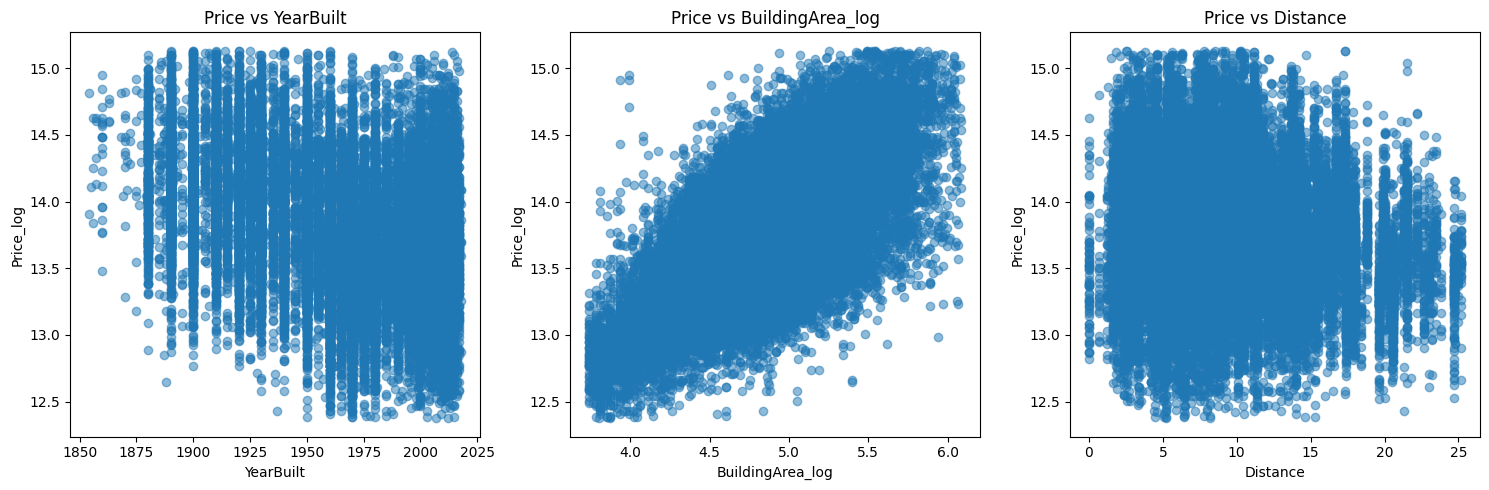

In [54]:

plt.figure(figsize=(15,5))
for i, feature in enumerate(continuous_vars, 1):
    plt.subplot(1,3,i)
    plt.scatter(X[feature], y, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Price_log')
    plt.title(f'Price vs {feature}')
plt.tight_layout()
plt.show()    

In [55]:
#Independence of the errors
print("\nChecking the independence of the errors")

model = sm.OLS(y, X_with_const).fit()
residuals = model.resid

#D-W test
durbin_watson = sm.stats.stattools.durbin_watson(residuals)
print(f"Durbin-Watson statistic: {durbin_watson:.4f}")
print("Interpretation:")
print("- Values close to 2 indicate no autocorrelation")
print("- Values < 1 or > 3 indicate potential autocorrelation")


Checking the independence of the errors
Durbin-Watson statistic: 1.5697
Interpretation:
- Values close to 2 indicate no autocorrelation
- Values < 1 or > 3 indicate potential autocorrelation



Checking Homoscedasticity


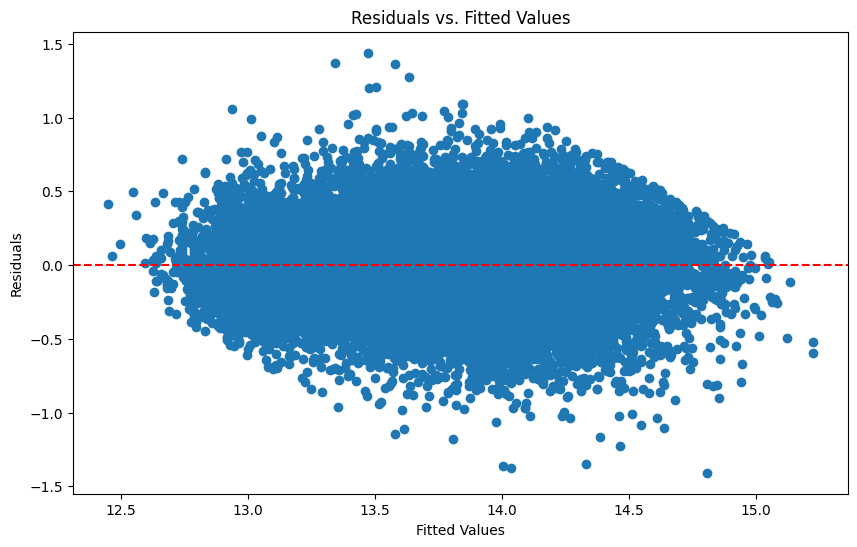

In [56]:
#Homoscedasticity

#Visualizing
print("\nChecking Homoscedasticity")
plt.figure(figsize=(10,6))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

In [57]:
#Breusch-Pagan Test:

bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X_with_const)
print(f"Breusch-Pagan test p-val: {bp_test[1]:.4f}")
print("Interpretation:")
print("- p-value < 0.05 suggests heteroscedasticity")
print("- p-value >= 0.05 suggests homoscedasticity")

Breusch-Pagan test p-val: 0.0000
Interpretation:
- p-value < 0.05 suggests heteroscedasticity
- p-value >= 0.05 suggests homoscedasticity


Since there the variance is not constant, transformation methods should be considered.

Before conducting transformation, removing outliers is essential.

In [58]:
def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]
    return df_cleaned

In [59]:
df_cleaned = remove_outliers_iqr(encoded_data, continuous_vars)

In [60]:
def check_normality(data, var_name):
    stat, p_value = stats.shapiro(data)

    plt.figure(figsize=(10,6))
    sns.histplot(data, kde=True)
    plt.title(f'Distribution of {var_name} (p-value: {p_value:.4f})')
    plt.show()

    return p_value


In [61]:
def try_transformation(data, var_name):
    data = data.dropna()
    values = data.values.reshape(-1, 1)

    transformations = {
        'Original': data,
        'Log': np.log1p(data),
        'Square-Root': np.sqrt(data),
        'Cube-Root': np.cbrt(data)
    }

    # Add Box-Cox only if strictly positive
    if (data > 0).all():
        try:
            box_cox = PowerTransformer(method='box-cox').fit_transform(values).ravel()
            transformations['Box-Cox'] = box_cox
        except Exception as e:
            print(f"Box-Cox failed: {e}")

    # Yeo-Johnson always safe
    try:
        yeo_johnson = PowerTransformer(method='yeo-johnson').fit_transform(values).ravel()
        transformations['Yeo-Johnson'] = yeo_johnson
    except Exception as e:
        print(f"Yeo-Johnson failed: {e}")

    # Plot and evaluate
    results = {}
    plt.figure(figsize=(15, 10))
    for i, (name, transformed) in enumerate(transformations.items(), 1):
        plt.subplot(2, 3, i)
        sns.histplot(transformed, kde=True)
        plt.title(f'{name} Transformation')

        skewness = stats.skew(transformed)
        kurtosis = stats.kurtosis(transformed)
        shapiro_p = stats.shapiro(transformed[:5000])[1] if len(transformed) > 5000 else stats.shapiro(transformed)[1]

        results[name] = {
            'skewness': skewness,
            'kurtosis': kurtosis,
            'shapiro_p': shapiro_p
        }

    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results).T
    print(f"\nTransformation results for {var_name}:")
    print(results_df)

    best_transform = results_df['shapiro_p'].idxmax()
    print(f"\nBest transformation for {var_name}: {best_transform}")
    print(f"Shapiro-Wilk p-value: {results_df.loc[best_transform, 'shapiro_p']:.4f}")

    return best_transform, transformations[best_transform]


Original Distribution:


/Users/aytug/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29049.
  res = hypotest_fun_out(*samples, **kwds)


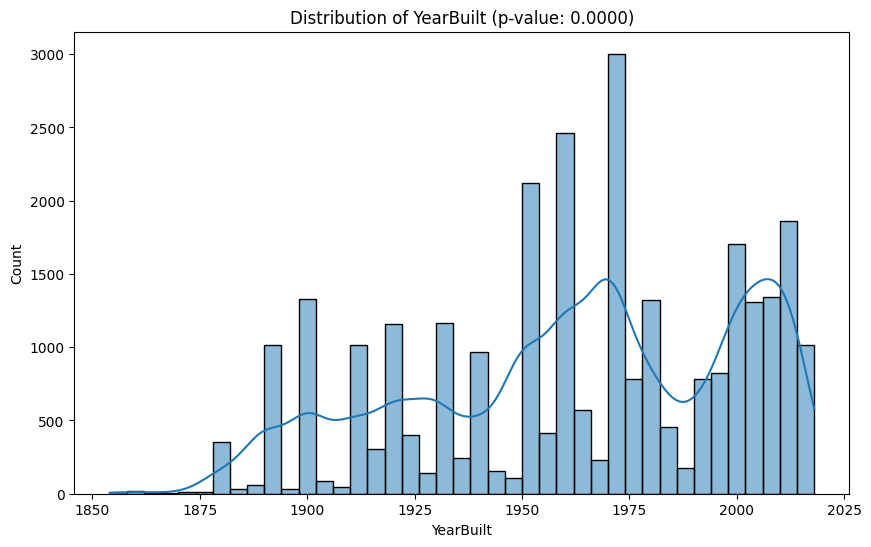


Trying Different Transformations:


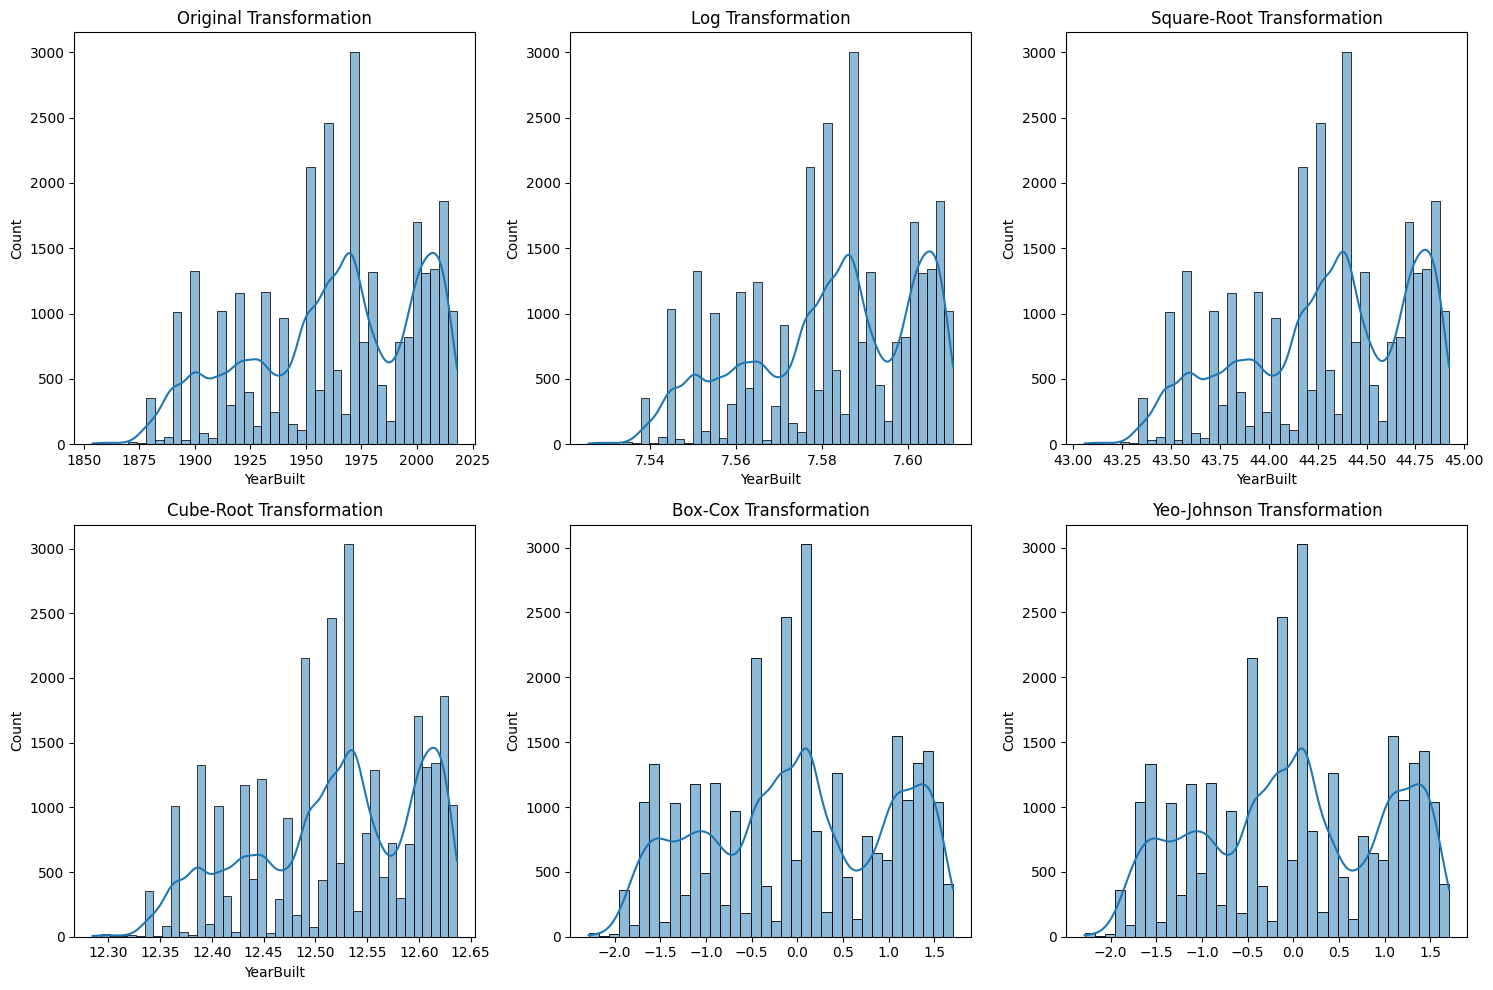


Transformation results for YearBuilt:
             skewness  kurtosis     shapiro_p
Original    -0.417833 -0.804794  8.342833e-38
Log         -0.447208 -0.770721  2.961285e-38
Square-Root -0.432501 -0.788010  5.018159e-38
Cube-Root   -0.437402 -0.782300  4.217380e-38
Box-Cox     -0.088129 -1.065197  1.182901e-35
Yeo-Johnson -0.088126 -1.065197  1.182958e-35

Best transformation for YearBuilt: Yeo-Johnson
Shapiro-Wilk p-value: 0.0000

Original Distribution:


/Users/aytug/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29049.
  res = hypotest_fun_out(*samples, **kwds)


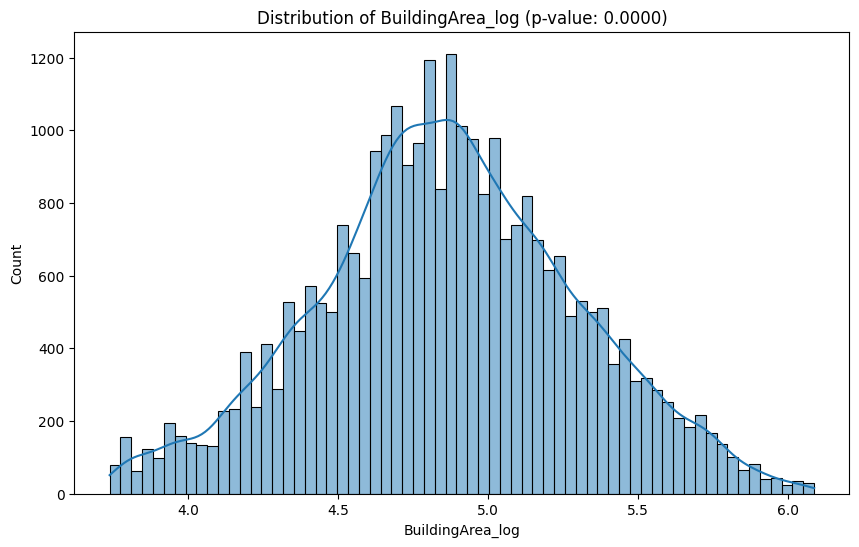


Trying Different Transformations:


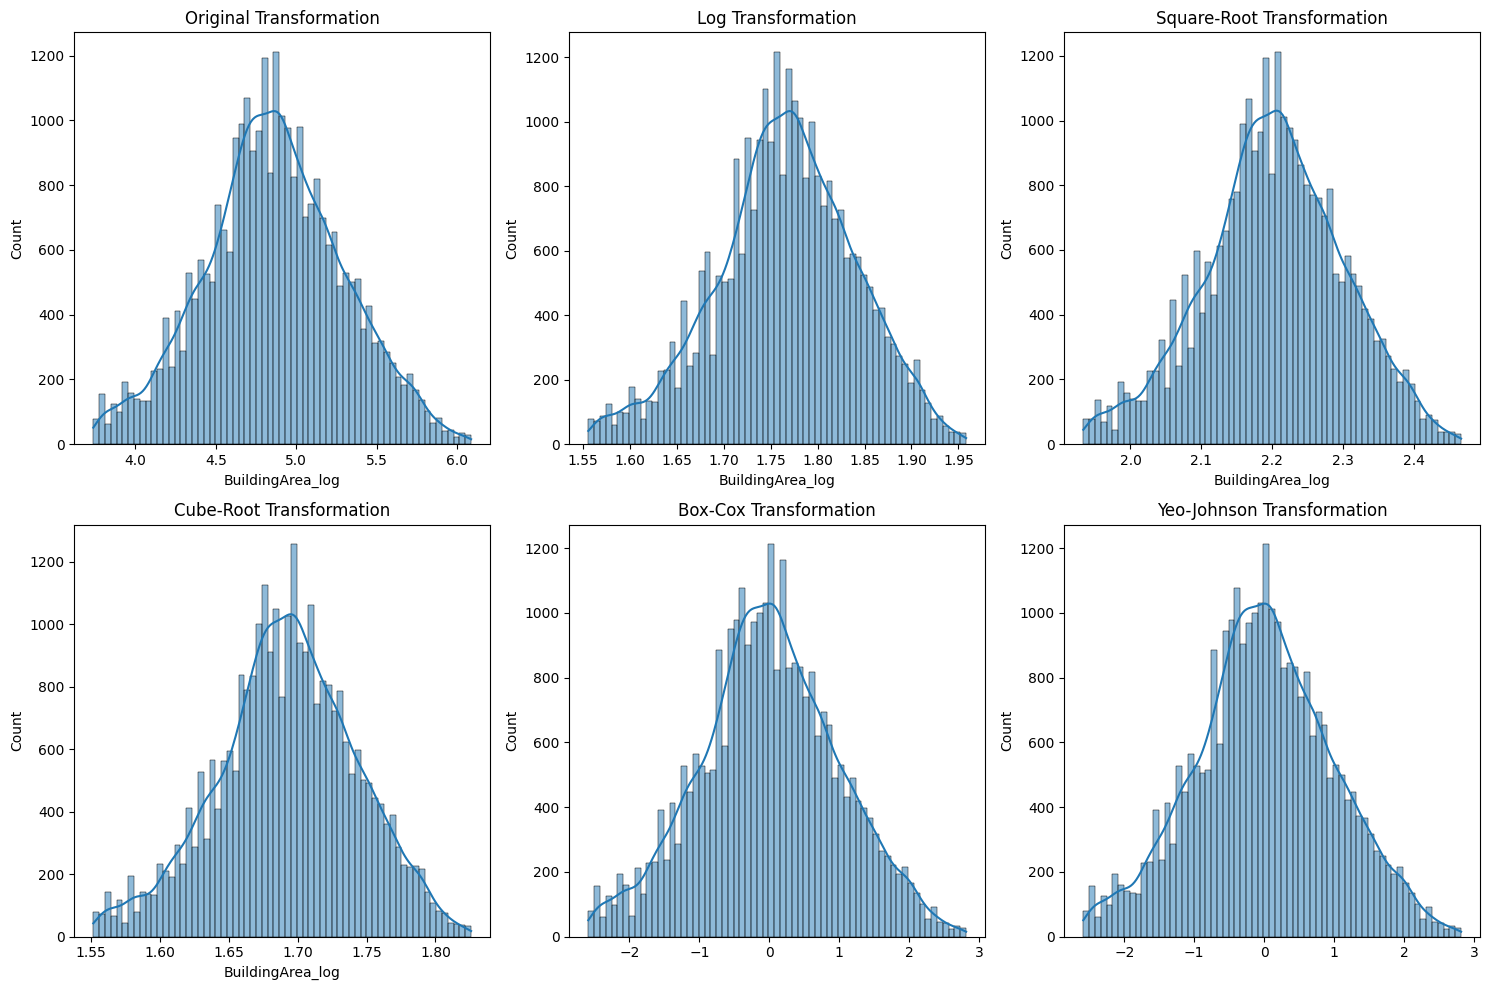


Transformation results for BuildingArea_log:
             skewness  kurtosis     shapiro_p
Original     0.000889 -0.172081  2.693070e-09
Log         -0.205570 -0.096380  5.837974e-11
Square-Root -0.123478 -0.138184  3.960932e-09
Cube-Root   -0.165315 -0.117679  6.770216e-10
Box-Cox     -0.005087 -0.171382  3.345950e-09
Yeo-Johnson -0.004186 -0.171559  3.237167e-09

Best transformation for BuildingArea_log: Square-Root
Shapiro-Wilk p-value: 0.0000

Original Distribution:


/Users/aytug/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29049.
  res = hypotest_fun_out(*samples, **kwds)


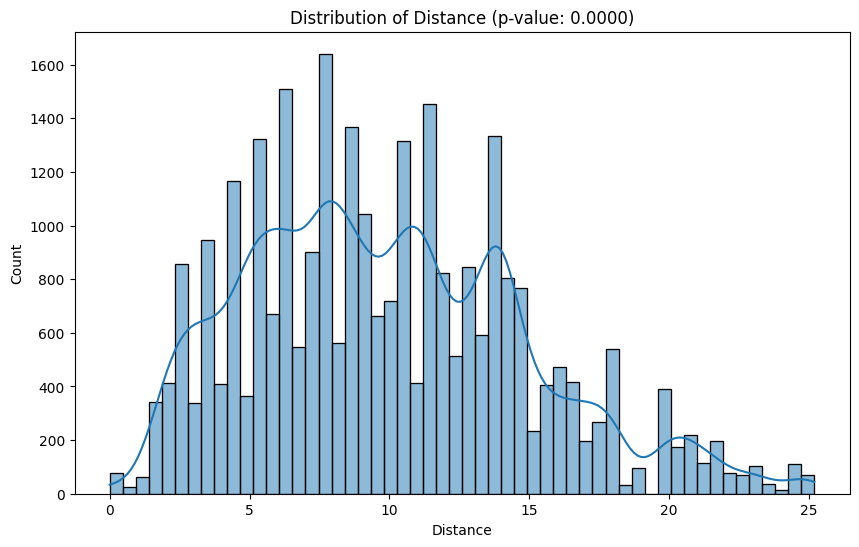


Trying Different Transformations:


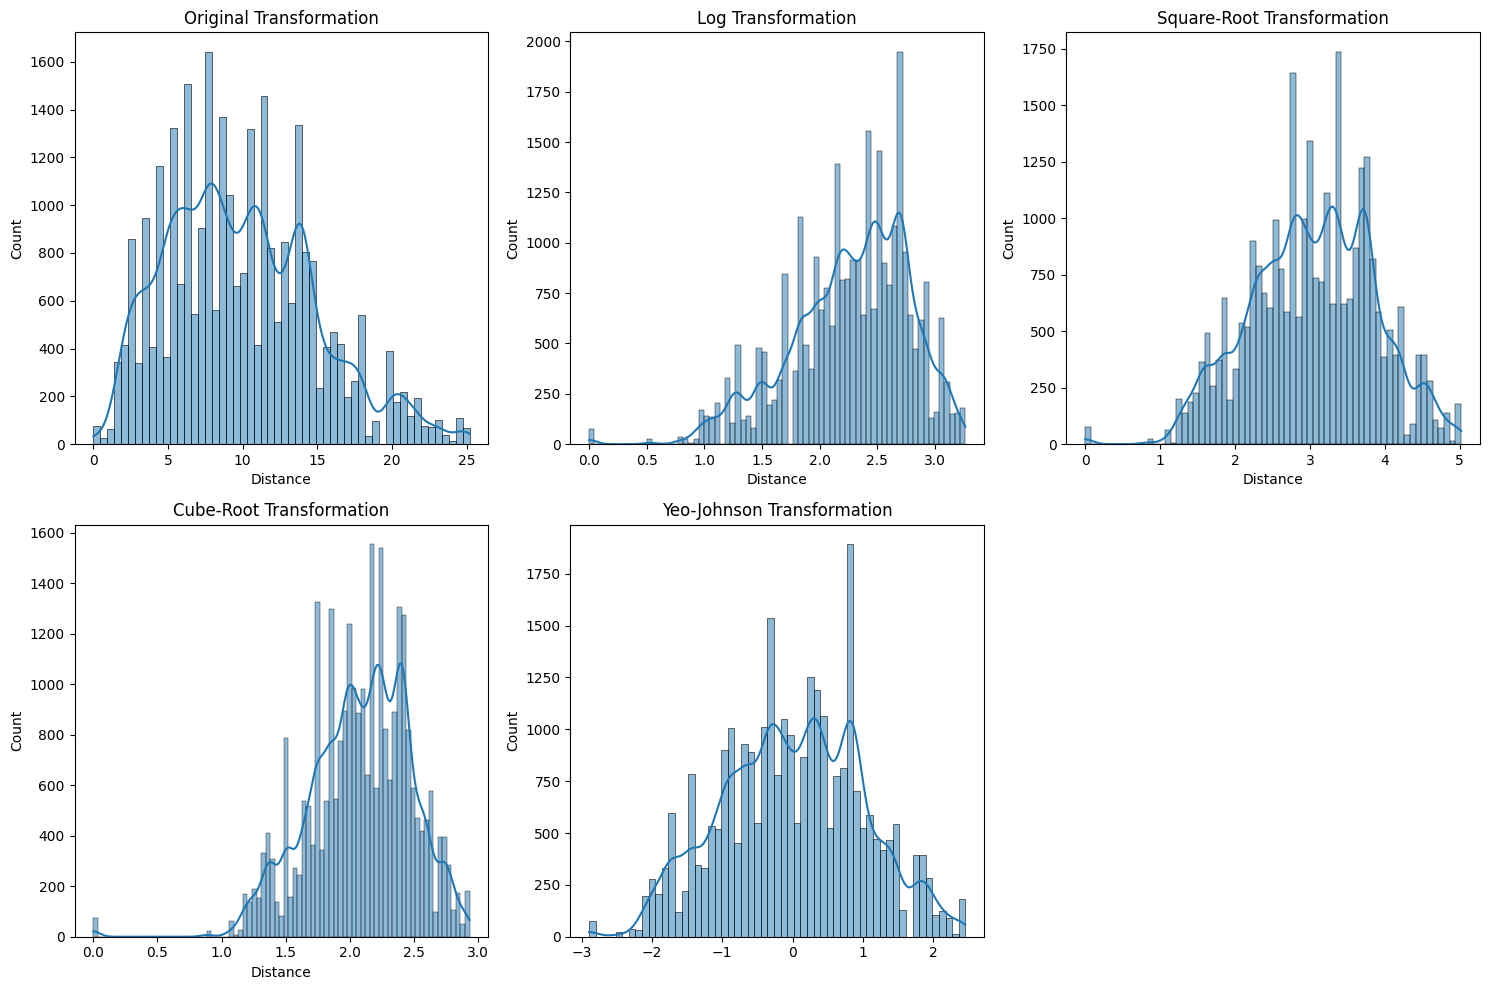


Transformation results for Distance:
             skewness  kurtosis     shapiro_p
Original     0.519203 -0.143558  2.235629e-27
Log         -0.697374  0.537104  2.974749e-34
Square-Root -0.162461 -0.187709  4.584573e-19
Cube-Root   -0.593940  1.250912  7.707886e-27
Yeo-Johnson -0.039884 -0.450899  2.382955e-18

Best transformation for Distance: Yeo-Johnson
Shapiro-Wilk p-value: 0.0000


In [62]:
best_transformations = {}

for var in df_cleaned[continuous_vars]:
    print("\nOriginal Distribution:")
    p_value = check_normality(X[var], var)

    print("\nTrying Different Transformations:")
    best_transform, transformed_data = try_transformation(X[var], var)
    best_transformations[var] = {
        'transformation': best_transform,
        'data': transformed_data
    }

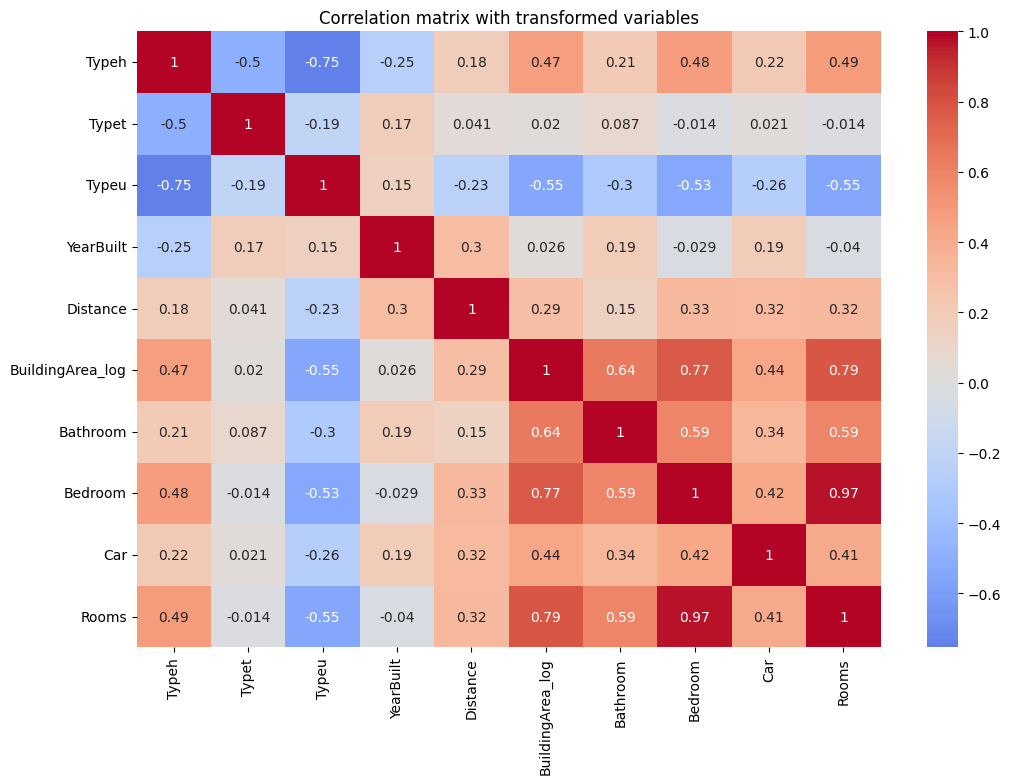

In [64]:
transformed_X = X.copy()
for var in continuous_vars:
    transformed_X[var] = best_transformations[var]['data']

plt.figure(figsize=(12,8))
correlation_matrix = transformed_X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title('Correlation matrix with transformed variables')
plt.show()

In [63]:
print("\n=== Summary of Best Transformations ===")
for var in continuous_vars:
    print(f"{var}: {best_transformations[var]['transformation']}")


=== Summary of Best Transformations ===
YearBuilt: Yeo-Johnson
BuildingArea_log: Square-Root
Distance: Yeo-Johnson


In [64]:
transformed_data = X.copy()
for var in continuous_vars:
    transformed_data[var] = best_transformations[var]['data']

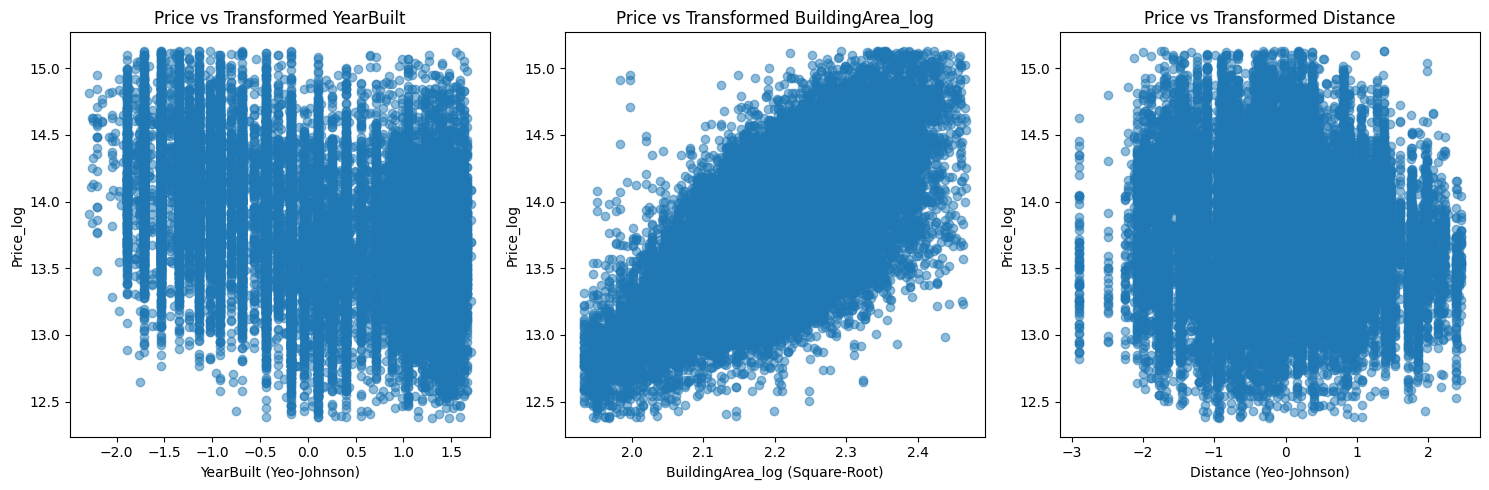

In [65]:
#original vs transformed
plt.figure(figsize=(15, 5))
for i, var in enumerate(continuous_vars, 1):
    plt.subplot(1, 3, i)
    plt.scatter(transformed_data[var], y, alpha=0.5)
    plt.xlabel(f'{var} ({best_transformations[var]["transformation"]})')
    plt.ylabel('Price_log')
    plt.title(f'Price vs Transformed {var}')
plt.tight_layout()
plt.show()

Updating the transformed data in the df that we are currently working on.

In [66]:
transformed_data = transformed_data.astype("float64")
encoded_data.update(transformed_data)

/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1043614156.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.10609432  1.62930096 -1.53545949 ...  0.88226143  0.10609432
  1.29779049]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  encoded_data.update(transformed_data)


In [71]:
encoded_data["Price_Class"] = encoded_data["Price_log"].apply(lambda x: "cheap" if x < median_price else "expensive")
encoded_data["Price_Class_Encoded"] = encoded_data["Price_Class"].map({"cheap": 0, "expensive": 1})

Although removing outliers and applied transformation to make the data normal, still there are issues about normality. Thus, binary logistic regression model can be built.

In [68]:
selected_vars = ["Typeh", "Typet", "Typeu", "YearBuilt", "Distance", "BuildingArea_log", "Bathroom", "Car", "Rooms"]

Cross - Validation Technique:

In [72]:
X = encoded_data[selected_vars]
y = encoded_data["Price_Class_Encoded"]

X_train, X_test, y_train, y_test = train_test_split(X ,y, stratify=y, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

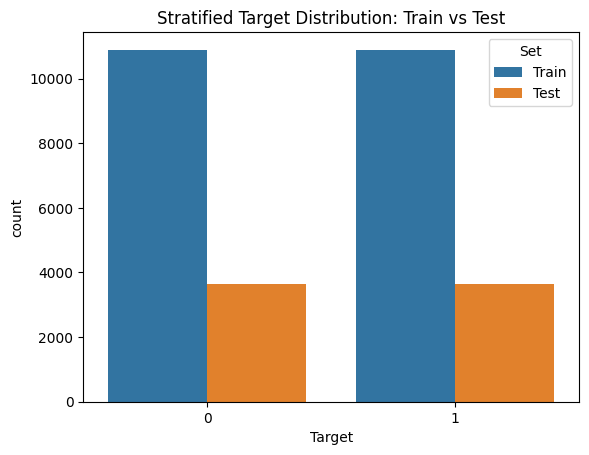

In [235]:
train_dist = pd.DataFrame({'Set': 'Train', 'Target': y_train})
test_dist = pd.DataFrame({'Set': 'Test', 'Target': y_test})
combined = pd.concat([train_dist, test_dist])

# Plot
sns.countplot(data=combined, x='Target', hue='Set')
plt.title('Stratified Target Distribution: Train vs Test')
plt.show()

Finding the metrics of the Binary Logistic Regression Model:

In [73]:
X = encoded_data[selected_vars]
y = encoded_data["Price_Class_Encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [212]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:340: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:340: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:340: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:341: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:341: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:341: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users

In [75]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

In [76]:
logreg = LogisticRegression(max_iter = 1000, random_state=42)

In [77]:
grid_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    n_jobs=1

)



In [214]:
grid_logreg.fit(X_train_pca, y_train)
best_logreg = grid_logreg.best_estimator_

y_test_pred_logreg = best_logreg.predict(X_test_pca)
y_train_pred_logreg = best_logreg.predict(X_train_pca)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/aytug/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:208: Run

In [215]:
train_cm_lr = confusion_matrix(y_train, y_train_pred_logreg)
train_accuracy_lr = accuracy_score(y_train, y_train_pred_logreg)
train_precision_lr = precision_score(y_train, y_train_pred_logreg)
train_recall_lr = recall_score(y_train, y_train_pred_logreg)
train_f1_lr = f1_score(y_train, y_train_pred_logreg)
train_kappa_lr = cohen_kappa_score(y_train, y_train_pred_logreg)

print("TRAIN SET METRICS")
print("Confusion Matrix:\n", train_cm_lr)
print(f"Accuracy:  {train_accuracy_lr:.4f}")
print(f"Precision: {train_precision_lr:.4f}")
print(f"Recall:    {train_recall_lr:.4f}")
print(f"F1 Score:  {train_f1_lr:.4f}")
print(f"Cohen's Kappa: {train_kappa_lr:.4f}")


TRAIN SET METRICS
Confusion Matrix:
 [[8677 2216]
 [2020 8873]]
Accuracy:  0.8056
Precision: 0.8002
Recall:    0.8146
F1 Score:  0.8073
Cohen's Kappa: 0.6111


In [216]:
test_cm_lr = confusion_matrix(y_test, y_test_pred_logreg)
test_accuracy_lr = accuracy_score(y_test, y_test_pred_logreg)
test_precision_lr = precision_score(y_test, y_test_pred_logreg)
test_recall_lr = recall_score(y_test, y_test_pred_logreg)
test_f1_lr = f1_score(y_test, y_test_pred_logreg)
test_kappa_lr = cohen_kappa_score(y_test, y_test_pred_logreg)

print("\nTEST SET METRICS")
print("Confusion Matrix:\n", test_cm_lr)
print(f"Accuracy:  {test_accuracy_lr:.4f}")
print(f"Precision: {test_precision_lr:.4f}")
print(f"Recall:    {test_recall_lr:.4f}")
print(f"F1 Score:  {test_f1_lr:.4f}")
print(f"Cohen's Kappa: {test_kappa_lr:.4f}")


TEST SET METRICS
Confusion Matrix:
 [[2880  751]
 [ 658 2974]]
Accuracy:  0.8060
Precision: 0.7984
Recall:    0.8188
F1 Score:  0.8085
Cohen's Kappa: 0.6120


Conducting ANN Model:

Building ANN Model:

In [166]:
encoded_data['Price_Class_Encoded'] = encoded_data['Price_Class'].map({'cheap': 0, 'expensive': 1})

In [187]:
X = encoded_data[selected_vars]

In [188]:
y = encoded_data["Price_Class_Encoded"]

In [189]:
#Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) 

In [217]:
#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)

In [221]:
def objective(trial):
    #suggestin hyperparameters
    units1 = trial.suggest_categorical("units1", [64, 128, 256])
    units2 = trial.suggest_categorical("units2", [32, 64])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    epochs = trial.suggest_int("epochs", 20, 50)

    accuracies = []

    for train_idx, val_idx in cv.split(X_train_pca, y_train):
        X_tr, X_val = X_train_pca[train_idx], X_train_pca[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = Sequential()
        model.add(Dense(units1, activation='relu', input_shape=(X_tr.shape[1],)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units2, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=Adam(learning_rate=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)

        y_val_pred = (model.predict(X_val) > 0.5).astype(int)
        acc = accuracy_score(y_val, y_val_pred)
        accuracies.append(acc)

    return np.mean(accuracies)


In [222]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-06-20 18:28:20,587] A new study created in memory with name: no-name-43dd0820-c51e-48ea-b030-8ecea55f9620
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


[I 2025-06-20 18:29:02,877] Trial 0 finished with value: 0.8131368942783596 and parameters: {'units1': 256, 'units2': 32, 'dropout_rate': 0.25431852264656357, 'learning_rate': 0.00683324344528648, 'batch_size': 32, 'epochs': 37}. Best is trial 0 with value: 0.8131368942783596.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


[I 2025-06-20 18:29:52,638] Trial 1 finished with value: 0.8143304813626177 and parameters: {'units1': 128, 'units2': 64, 'dropout_rate': 0.20459560928589965, 'learning_rate': 0.0010611958993501699, 'batch_size': 32, 'epochs': 48}. Best is trial 1 with value: 0.8143304813626177.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


[I 2025-06-20 18:30:43,458] Trial 2 finished with value: 0.8136419025979093 and parameters: {'units1': 128, 'units2': 32, 'dropout_rate': 0.33086827711491357, 'learning_rate': 0.00010333390322798075, 'batch_size': 32, 'epochs': 49}. Best is trial 1 with value: 0.8143304813626177.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


[I 2025-06-20 18:31:25,488] Trial 3 finished with value: 0.8135501384414819 and parameters: {'units1': 64, 'units2': 64, 'dropout_rate': 0.2954045363762669, 'learning_rate': 0.00022119387785431404, 'batch_size': 32, 'epochs': 41}. Best is trial 1 with value: 0.8143304813626177.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


[I 2025-06-20 18:31:41,172] Trial 4 finished with value: 0.8118976252443278 and parameters: {'units1': 64, 'units2': 32, 'dropout_rate': 0.27313861364295444, 'learning_rate': 0.0001293113979737007, 'batch_size': 64, 'epochs': 26}. Best is trial 1 with value: 0.8143304813626177.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step


[I 2025-06-20 18:31:56,047] Trial 5 finished with value: 0.8128156670654839 and parameters: {'units1': 128, 'units2': 32, 'dropout_rate': 0.24095664386013732, 'learning_rate': 0.00023933989178503908, 'batch_size': 64, 'epochs': 22}. Best is trial 1 with value: 0.8143304813626177.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


[I 2025-06-20 18:32:48,234] Trial 6 finished with value: 0.8148352474214242 and parameters: {'units1': 64, 'units2': 32, 'dropout_rate': 0.37013438183388847, 'learning_rate': 0.0005709199710413989, 'batch_size': 32, 'epochs': 50}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


[I 2025-06-20 18:33:14,113] Trial 7 finished with value: 0.8127699429834074 and parameters: {'units1': 128, 'units2': 32, 'dropout_rate': 0.4192652541511824, 'learning_rate': 0.0006292309705555298, 'batch_size': 32, 'epochs': 24}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


[I 2025-06-20 18:33:38,945] Trial 8 finished with value: 0.8115764296306798 and parameters: {'units1': 64, 'units2': 64, 'dropout_rate': 0.2752766625836109, 'learning_rate': 0.00014615948332413146, 'batch_size': 32, 'epochs': 22}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


[I 2025-06-20 18:34:07,689] Trial 9 finished with value: 0.8131829448857861 and parameters: {'units1': 64, 'units2': 32, 'dropout_rate': 0.4001301171934652, 'learning_rate': 0.007545015706105933, 'batch_size': 64, 'epochs': 48}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


[I 2025-06-20 18:34:29,724] Trial 10 finished with value: 0.8146517296416447 and parameters: {'units1': 256, 'units2': 64, 'dropout_rate': 0.49005300481536807, 'learning_rate': 0.001973910442513497, 'batch_size': 64, 'epochs': 30}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step


[I 2025-06-20 18:34:52,764] Trial 11 finished with value: 0.8142844202221152 and parameters: {'units1': 256, 'units2': 64, 'dropout_rate': 0.49981144398256067, 'learning_rate': 0.0019971899324215045, 'batch_size': 64, 'epochs': 31}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


[I 2025-06-20 18:35:16,310] Trial 12 finished with value: 0.8129532817008979 and parameters: {'units1': 256, 'units2': 64, 'dropout_rate': 0.4970219898685877, 'learning_rate': 0.0019151056009387856, 'batch_size': 64, 'epochs': 32}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


[I 2025-06-20 18:35:45,578] Trial 13 finished with value: 0.8133665047978689 and parameters: {'units1': 256, 'units2': 64, 'dropout_rate': 0.43310532901699367, 'learning_rate': 0.0005635151297374453, 'batch_size': 64, 'epochs': 40}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


[I 2025-06-20 18:36:20,030] Trial 14 finished with value: 0.81465166644319 and parameters: {'units1': 256, 'units2': 32, 'dropout_rate': 0.36599963905265465, 'learning_rate': 0.003223196783916025, 'batch_size': 32, 'epochs': 31}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


[I 2025-06-20 18:36:47,268] Trial 15 finished with value: 0.8139632035423154 and parameters: {'units1': 64, 'units2': 64, 'dropout_rate': 0.4551128890219527, 'learning_rate': 0.00048502253332134346, 'batch_size': 64, 'epochs': 44}. Best is trial 6 with value: 0.8148352474214242.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


[I 2025-06-20 18:37:15,022] Trial 16 finished with value: 0.8148352579544997 and parameters: {'units1': 64, 'units2': 32, 'dropout_rate': 0.35579026425749083, 'learning_rate': 0.0012679560239625075, 'batch_size': 32, 'epochs': 27}. Best is trial 16 with value: 0.8148352579544997.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


[I 2025-06-20 18:37:51,037] Trial 17 finished with value: 0.8152022513817553 and parameters: {'units1': 64, 'units2': 32, 'dropout_rate': 0.3624916984833705, 'learning_rate': 0.0007833414258830648, 'batch_size': 32, 'epochs': 36}. Best is trial 17 with value: 0.8152022513817553.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


[I 2025-06-20 18:38:18,681] Trial 18 finished with value: 0.8157991713207939 and parameters: {'units1': 64, 'units2': 32, 'dropout_rate': 0.32997724710843845, 'learning_rate': 0.0011076705593831492, 'batch_size': 32, 'epochs': 27}. Best is trial 18 with value: 0.8157991713207939.
/var/folders/n8/3fntt4ks33b8qnc_3py663qw0000gn/T/ipykernel_15124/1386868586.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


[I 2025-06-20 18:38:54,510] Trial 19 finished with value: 0.8132746669099105 and parameters: {'units1': 64, 'units2': 32, 'dropout_rate': 0.3206262179086927, 'learning_rate': 0.0002823063899853046, 'batch_size': 32, 'epochs': 36}. Best is trial 18 with value: 0.8157991713207939.


In [223]:
print("Best trial:")
print(study.best_trial.params)

Best trial:
{'units1': 64, 'units2': 32, 'dropout_rate': 0.32997724710843845, 'learning_rate': 0.0011076705593831492, 'batch_size': 32, 'epochs': 27}


In [224]:
#training final model with best parameters
best_params = study.best_trial.params

final_model = Sequential()
final_model.add(Dense(best_params["units1"], activation='relu', input_shape=(X_train_pca.shape[1],)))
final_model.add(Dropout(best_params["dropout_rate"]))
final_model.add(Dense(best_params["units2"], activation='relu'))
final_model.add(Dropout(best_params["dropout_rate"]))
final_model.add(Dense(1, activation='sigmoid'))

/Users/aytug/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [225]:
final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

final_model.fit(X_train_pca, y_train,
                epochs=best_params["epochs"],
                batch_size=best_params["batch_size"],
                verbose=1)

Epoch 1/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - accuracy: 0.7436 - loss: 0.5017
Epoch 2/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.8044 - loss: 0.4233
Epoch 3/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - accuracy: 0.8130 - loss: 0.4102
Epoch 4/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - accuracy: 0.8068 - loss: 0.4156
Epoch 5/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.8092 - loss: 0.4140
Epoch 6/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.8088 - loss: 0.4121
Epoch 7/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - accuracy: 0.8106 - loss: 0.4100
Epoch 8/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - accuracy: 0.8130 - loss: 0.4108
Epoch 9/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - accuracy: 0.8121 - loss: 0.4091
Epoch 10/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - accuracy: 0.8064 - loss: 0.4121
Epoch 11/27
681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - accuracy: 0.8101 - loss: 0.4097
Epoch 12/27
681/681 ━━━━━━━━━━

In [226]:
y_pred = (final_model.predict(X_test_pca) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      3631
           1       0.80      0.82      0.81      3632

    accuracy                           0.81      7263
   macro avg       0.81      0.81      0.81      7263
weighted avg       0.81      0.81      0.81      7263



Calculation for train set:

In [227]:
y_train_pred_probs_ann = final_model.predict(X_train_pca)
y_train_pred_ann = (y_train_pred_probs_ann > 0.5).astype(int)

train_accuracy_ann = accuracy_score(y_train, y_train_pred_ann)
train_precision_ann = precision_score(y_train, y_train_pred_ann)
train_recall_ann = recall_score(y_train, y_train_pred_ann)
train_f1_ann = f1_score(y_train, y_train_pred_ann)
train_kappa_ann = cohen_kappa_score(y_train, y_train_pred_ann)
train_cm_ann = confusion_matrix(y_train, y_train_pred_ann)

print("TRAIN SET METRICS")
print("Confusion Matrix:\n", train_cm_ann)
print(f"Accuracy:  {train_accuracy_ann:.4f}")
print(f"Precision: {train_precision_ann:.4f}")
print(f"Recall:    {train_recall_ann:.4f}")
print(f"F1 Score:  {train_f1_ann:.4f}")
print(f"Kappa:  {train_kappa_ann:.4f}")

681/681 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step
TRAIN SET METRICS
Confusion Matrix:
 [[8794 2099]
 [1891 9002]]
Accuracy:  0.8169
Precision: 0.8109
Recall:    0.8264
F1 Score:  0.8186
Kappa:  0.6337


Calculation for test set:

In [228]:
y_test_pred_probs_ann = final_model.predict(X_test_scaled)
y_test_pred_ann = (y_test_pred_probs_ann > 0.5).astype(int)

test_accuracy_ann = accuracy_score(y_test, y_test_pred_ann)
test_precision_ann = precision_score(y_test, y_test_pred_ann)
test_recall_ann = recall_score(y_test, y_test_pred_ann)
test_f1_ann = f1_score(y_test, y_test_pred_ann)
test_kappa_ann = cohen_kappa_score(y_test, y_test_pred_ann)
test_cm_ann = confusion_matrix(y_test, y_test_pred_ann)

print("\nTEST SET METRICS")
print("Confusion Matrix:\n", test_cm_ann)
print(f"Accuracy:  {test_accuracy_ann:.4f}")
print(f"Precision: {test_precision_ann:.4f}")
print(f"Recall:    {test_recall_ann:.4f}")
print(f"F1 Score:  {test_f1_ann:.4f}")
print(f"Kappa:  {test_kappa_ann:.4f}")

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step

TEST SET METRICS
Confusion Matrix:
 [[2748  883]
 [ 786 2846]]
Accuracy:  0.7702
Precision: 0.7632
Recall:    0.7836
F1 Score:  0.7733
Kappa:  0.5404


Constructing SVM Model:

In [201]:
X = encoded_data[selected_vars]
y = encoded_data["Price_Class_Encoded"]

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [229]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

In [230]:
svc = SVC(probability=True)
grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train_pca, y_train)

# Best model
best_svm = grid_search.best_estimator_

print("\nBest Parameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [231]:
y_train_pred_probs_svm = best_svm.predict(X_train_pca)
y_train_pred_svm = (y_train_pred_probs_svm > 0.5).astype(int)

train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
train_precision_svm = precision_score(y_train, y_train_pred_svm)
train_recall_svm = recall_score(y_train, y_train_pred_svm)
train_f1_svm = f1_score(y_train, y_train_pred_svm)
train_kappa_svm = cohen_kappa_score(y_train, y_train_pred_svm)
train_cm_svm = confusion_matrix(y_train, y_train_pred_svm)

print("\nTRAIN SET METRICS")
print("Confusion Matrix:\n", train_cm_svm)
print(f"Accuracy:  {train_accuracy_svm:.4f}")
print(f"Precision: {train_precision_svm:.4f}")
print(f"Recall:    {train_recall_svm:.4f}")
print(f"F1 Score:  {train_f1_svm:.4f}")
print(f"Kappa:  {train_kappa_svm:.4f}")


TRAIN SET METRICS
Confusion Matrix:
 [[8831 2062]
 [1834 9059]]
Accuracy:  0.8212
Precision: 0.8146
Recall:    0.8316
F1 Score:  0.8230
Kappa:  0.6423


In [232]:
y_test_pred_probs_svm = best_svm.predict(X_test_pca)
y_test_pred_svm = (y_test_pred_probs_svm > 0.5).astype(int)

test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
test_precision_svm = precision_score(y_test, y_test_pred_svm)
test_recall_svm = recall_score(y_test, y_test_pred_svm)
test_f1_svm = f1_score(y_test, y_test_pred_svm)
test_kappa_svm = cohen_kappa_score(y_test, y_test_pred_svm)
test_cm_svm = confusion_matrix(y_test, y_test_pred_svm)

print("\nTEST SET METRICS")
print("Confusion Matrix:\n", test_cm_svm)
print(f"Accuracy:  {test_accuracy_svm:.4f}")
print(f"Precision: {test_precision_svm:.4f}")
print(f"Recall:    {test_recall_svm:.4f}")
print(f"F1 Score:  {test_f1_svm:.4f}")
print(f"Kappa:    {test_kappa_svm:.4f}")


TEST SET METRICS
Confusion Matrix:
 [[2912  719]
 [ 631 3001]]
Accuracy:  0.8141
Precision: 0.8067
Recall:    0.8263
F1 Score:  0.8164
Kappa:    0.6283


Constructing RF Model with tuning:

In [114]:
X = encoded_data[selected_vars]
y = encoded_data["Price_Class_Encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [104]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_

print("\nBest Parameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters:
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [105]:
y_train_pred_probs_rf = best_rf.predict(X_train_scaled)
y_train_pred_rf = (y_train_pred_probs_rf > 0.5).astype(int)

train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_precision_rf = precision_score(y_train, y_train_pred_rf)
train_recall_rf = recall_score(y_train, y_train_pred_rf)
train_f1_rf = f1_score(y_train, y_train_pred_rf)
train_cm_rf = confusion_matrix(y_train, y_train_pred_rf)

print("\nTRAIN SET METRICS")
print("Confusion Matrix:\n", train_cm_rf)
print(f"Accuracy:  {train_accuracy_rf:.4f}")
print(f"Precision: {train_precision_rf:.4f}")
print(f"Recall:    {train_recall_rf:.4f}")
print(f"F1 Score:  {train_f1_rf:.4f}")


TRAIN SET METRICS
Confusion Matrix:
 [[10207   686]
 [  652 10241]]
Accuracy:  0.9386
Precision: 0.9372
Recall:    0.9401
F1 Score:  0.9387


In [106]:
y_test_pred_probs_rf = best_rf.predict(X_test_scaled)
y_test_pred_rf = (y_test_pred_probs_rf > 0.5).astype(int)

test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_precision_rf = precision_score(y_test, y_test_pred_rf)
test_recall_rf = recall_score(y_test, y_test_pred_rf)
test_f1_rf = f1_score(y_test, y_test_pred_rf)
test_cm_rf = confusion_matrix(y_test, y_test_pred_rf)

print("\nTEST SET METRICS")
print("Confusion Matrix:\n", test_cm_rf)
print(f"Accuracy:  {test_accuracy_rf:.4f}")
print(f"Precision: {test_precision_rf:.4f}")
print(f"Recall:    {test_recall_rf:.4f}")
print(f"F1 Score:  {test_f1_rf:.4f}")


TEST SET METRICS
Confusion Matrix:
 [[3025  606]
 [ 588 3044]]
Accuracy:  0.8356
Precision: 0.8340
Recall:    0.8381
F1 Score:  0.8360


Constructing XGBoost model with tuning:

In [189]:
X = encoded_data[selected_vars]
y = encoded_data["Price_Class_Encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [190]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xg_clf = xg.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [191]:
grid_search = GridSearchCV(xg_clf, param_grid, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_xgb = grid_search.best_estimator_

print("\nBest Parameters:")
print(grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/aytug/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aytug/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [11:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U


Best Parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [192]:
y_train_pred_probs_xgb = best_xgb.predict(X_train_scaled)
y_train_pred_xgb = (y_train_pred_probs_xgb > 0.5).astype(int)


train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
train_precision_xgb = precision_score(y_train, y_train_pred_xgb)
train_recall_xgb = recall_score(y_train, y_train_pred_xgb)
train_f1_xgb = f1_score(y_train, y_train_pred_xgb)
train_cm_xgb = confusion_matrix(y_train, y_train_pred_xgb)

print("\nTRAIN SET METRICS")
print("Confusion Matrix:\n", train_cm_xgb)
print(f"Accuracy:  {train_accuracy_xgb:.4f}")
print(f"Precision: {train_precision_xgb:.4f}")
print(f"Recall:    {train_recall_xgb:.4f}")
print(f"F1 Score:  {train_f1_xgb:.4f}")


TRAIN SET METRICS
Confusion Matrix:
 [[9511 1382]
 [1344 9549]]
Accuracy:  0.8749
Precision: 0.8736
Recall:    0.8766
F1 Score:  0.8751


In [193]:
y_test_pred_probs_xgb = best_xgb.predict(X_test_scaled)
y_test_pred_xgb = (y_test_pred_probs_xgb > 0.5).astype(int)

test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_precision_xgb = precision_score(y_test, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test, y_test_pred_xgb)
test_cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

print("\nTEST SET METRICS")
print("Confusion Matrix:\n", test_cm_xgb)
print(f"Accuracy:  {test_accuracy_xgb:.4f}")
print(f"Precision: {test_precision_xgb:.4f}")
print(f"Recall:    {test_recall_xgb:.4f}")
print(f"F1 Score:  {test_f1_xgb:.4f}")


TEST SET METRICS
Confusion Matrix:
 [[3075  556]
 [ 512 3120]]
Accuracy:  0.8530
Precision: 0.8487
Recall:    0.8590
F1 Score:  0.8539


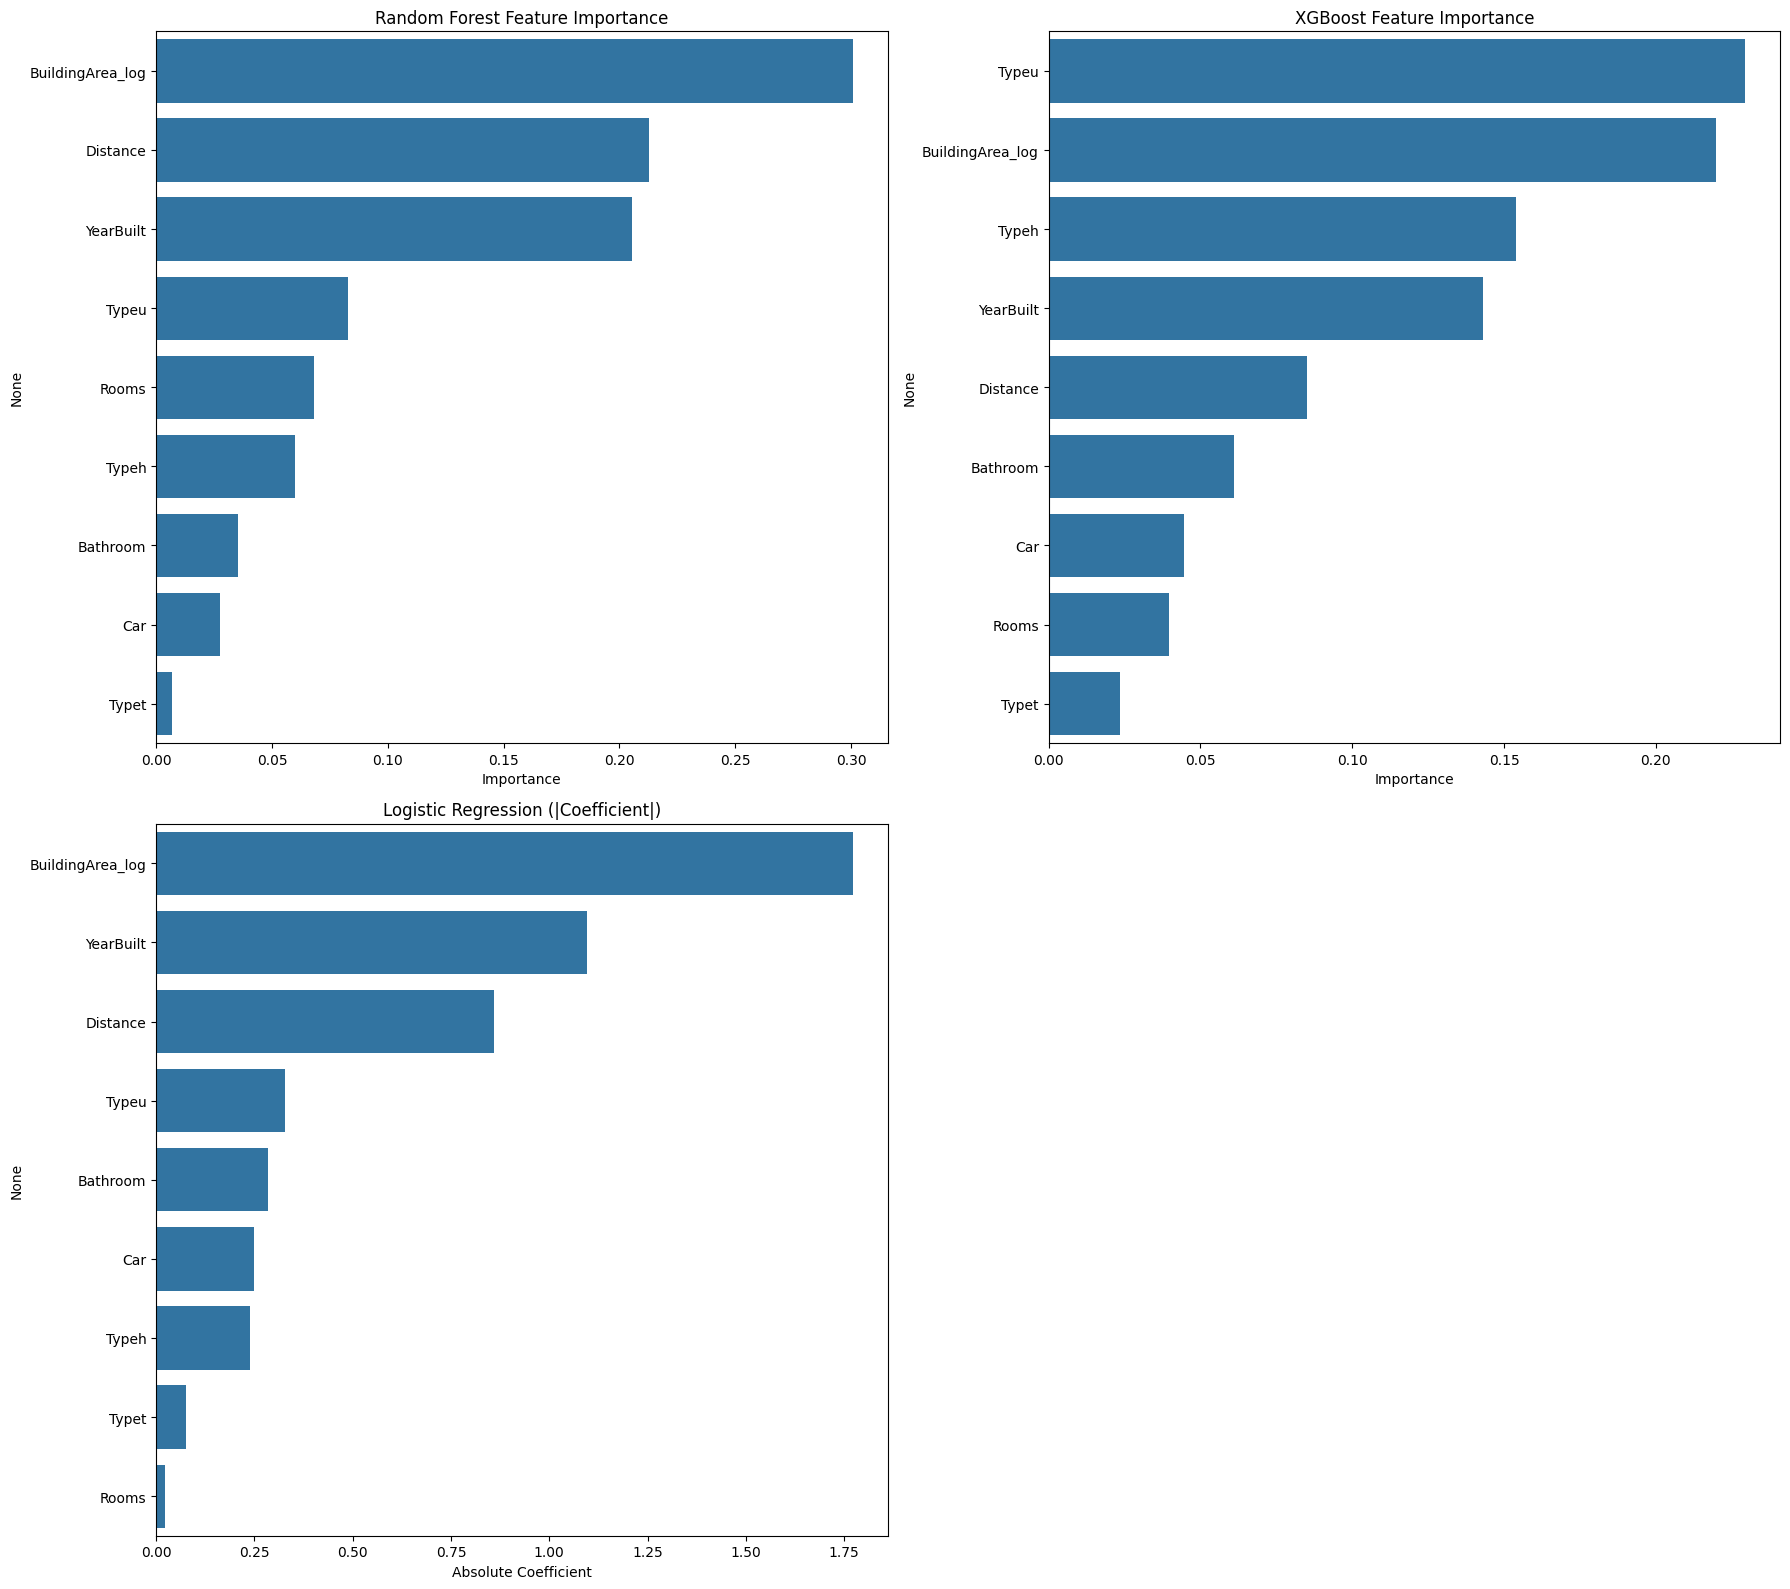

In [198]:
# --- Random Forest Importance ---
rf_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# --- XGBoost Importance ---
xgb_importances = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# --- Logistic Regression Importance (absolute value of coefficients) ---
logreg_importances = pd.Series(np.abs(best_logreg.coef_[0]), index=X.columns).sort_values(ascending=False)

# --- SVM Importance (if linear kernel) ---
if hasattr(best_svm, "coef_"):
    svm_importances = pd.Series(np.abs(best_svm.coef_[0]), index=X.columns).sort_values(ascending=False)
else:
    svm_importances = None

plt.figure(figsize=(18,16))

# RF
plt.subplot(2, 2, 1)
sns.barplot(x=rf_importances.values[:15], y=rf_importances.index[:15])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")

# XGBoost
plt.subplot(2, 2, 2)
sns.barplot(x=xgb_importances.values[:15], y=xgb_importances.index[:15])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")

# Logistic Regression
plt.subplot(2, 2, 3)
sns.barplot(x=logreg_importances.values[:15], y=logreg_importances.index[:15])
plt.title("Logistic Regression (|Coefficient|)")
plt.xlabel("Absolute Coefficient")

# SVM (if applicable)
if svm_importances is not None:
    plt.subplot(2, 2, 4)
    sns.barplot(x=svm_importances.values[:15], y=svm_importances.index[:15])
    plt.title("SVM (Linear Kernel) Feature Importance")
    plt.xlabel("Absolute Coefficient")

plt.tight_layout()
plt.show()

For tabulation of the Price_Class:

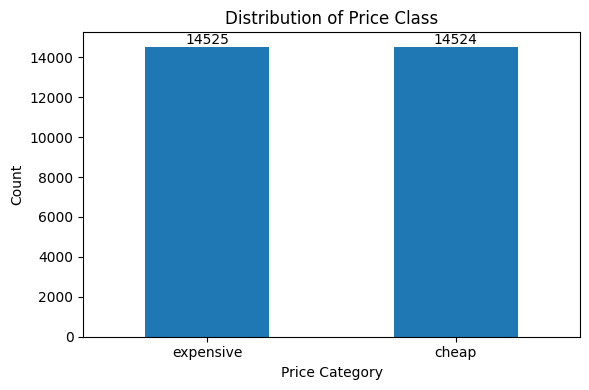

In [202]:
# Count occurrences
counts = encoded_data['Price_Class'].value_counts()

# Plot
plt.figure(figsize=(6, 4))
counts.plot(kind='bar')
plt.title('Distribution of Price Class')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.xticks(rotation=0)

for i, value in enumerate(counts):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

In [201]:
encoded_data['Price_Class'].value_counts()

Price_Class
expensive    14525
cheap        14524
Name: count, dtype: int64

In [209]:
encoded_data['Distance_abs'] = encoded_data['Distance'].abs()

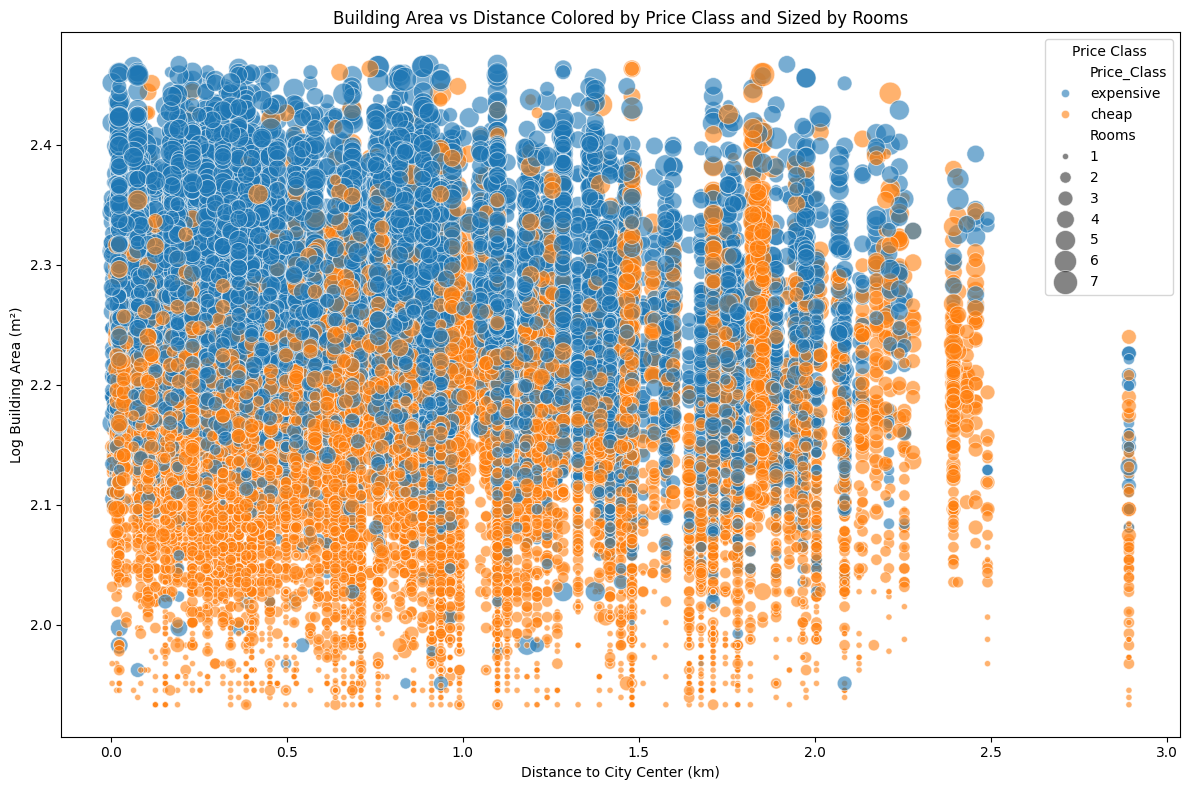

In [210]:
plt.figure(figsize=(12, 8))

# Bubble plot
sns.scatterplot(
    data=encoded_data,
    x='Distance_abs',
    y='BuildingArea_log',
    size='Rooms',
    hue='Price_Class',
    alpha=0.6,
    sizes=(20, 300)
)

plt.title('Building Area vs Distance Colored by Price Class and Sized by Rooms')
plt.xlabel('Distance to City Center (km)')
plt.ylabel('Log Building Area (m²)')
plt.legend(title='Price Class')
plt.tight_layout()
plt.show()

In [211]:
from scipy.stats import kruskal

# Split data into groups
group_cheap = encoded_data[encoded_data['Price_Class'] == 'cheap']['BuildingArea_log']
group_expensive = encoded_data[encoded_data['Price_Class'] == 'expensive']['BuildingArea_log']

# Kruskal-Wallis test
stat, p = kruskal(group_cheap, group_expensive)

print(f"Kruskal-Wallis H-statistic: {stat:.4f}, p-value: {p:.4f}")

Kruskal-Wallis H-statistic: 8233.6419, p-value: 0.0000
